In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import pandas as pd
import keras
import tensorflow as tf
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator 
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers.convolutional import Conv2D,Conv1D
from keras.layers.pooling import MaxPooling2D
from keras.layers import Concatenate
from keras.optimizers import Adam, SGD
from keras.regularizers import l1, l2
from matplotlib import pyplot as plt
#from sklearn.metrics import confusion_matrix

In [2]:
df = pd.read_csv('./fer2013/fer2013.csv')
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [3]:
x_train = []
y_train = []
x_test = []
y_test = []
for index, row in df.iterrows():
    k = row['pixels'].split(" ")
    if row['Usage'] == 'Training':
        x_train.append(np.array(k))
        y_train.append(row['emotion'])
    elif row['Usage'] == 'PublicTest':
        x_test.append(np.array(k))
        y_test.append(row['emotion'])

In [4]:
x_train = np.array(x_train, dtype = 'uint8')
y_train = np.array(y_train, dtype = 'uint8')
x_test = np.array(x_test, dtype = 'uint8')
y_test = np.array(y_test, dtype = 'uint8')

In [5]:
y_train= to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)

In [6]:
x_train = x_train.reshape(x_train.shape[0], 48, 48, 1)
x_test = x_test.reshape(x_test.shape[0], 48, 48, 1)

In [7]:
x_train = np.stack((x_train,)*3, axis=4)
x_train = x_train.reshape(x_train.shape[0],48,48,3)
x_test = np.stack((x_test,)*3, axis=4)
x_test = x_test.reshape(x_test.shape[0],48,48,3)

In [8]:
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (28709, 48, 48, 3) - y_train shape: (28709, 7)
x_test shape: (3589, 48, 48, 3) - y_test shape: (3589, 7)


In [9]:
datagen = ImageDataGenerator( 
    rescale=1./255,
    rotation_range = 30,
    horizontal_flip = True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range = 0.2,
    fill_mode = 'nearest')

datagen.fit(x_train)

testgen = ImageDataGenerator(rescale=1./255)

In [10]:
batch_size = 32
train_flow = datagen.flow(x_train, y_train, batch_size=batch_size) 
test_flow = testgen.flow(x_test, y_test, batch_size=batch_size)

In [9]:
def FER_Model(input_shape=(48,48,3)):
    visible = Input(shape=input_shape, name='input')
    num_classes = 7
    x = Conv2D(filters=256,kernel_size=3,activation='relu',padding='same')(visible)
    x = Conv2D(filters=512,kernel_size=3,activation='relu',padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Dropout(0.4)(x)

    x = Conv2D(filters=384,kernel_size=3,activation='relu',padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Dropout(0.4)(x)

    x = Conv2D(filters=192,kernel_size=3,activation='relu',padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Dropout(0.4)(x)


    x = Conv2D(filters=384,kernel_size=3,activation='relu',padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Dropout(0.4)(x)

    x = Flatten()(x)

    x = Dense(256,activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    output = Dense(num_classes,activation='softmax')(x)
    model = Model(inputs =visible, outputs = output)
    # summary layers
    print(model.summary())
    
    return model

In [23]:
config = tf.compat.v1.ConfigProto( device_count = {'GPU': 1 , 'CPU': 12} ) 
sess = tf.compat.v1.Session(config=config) 
tf.compat.v1.keras.backend.set_session(sess)

In [18]:
model = FER_Model()
opt = Adam(lr=0.001, decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 48, 48, 3)]       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 48, 48, 256)       7168      
                                                                 
 conv2d_6 (Conv2D)           (None, 48, 48, 512)       1180160   
                                                                 
 batch_normalization_5 (Batc  (None, 48, 48, 512)      2048      
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 24, 24, 512)      0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 24, 24, 512)       0   

In [15]:
checkpoint_filepath = "./tmp-cnn/checkpoint-model-custom-cnn-adam-300-epoch"
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    checkpoint_filepath,
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=True,
)

In [17]:
num_epochs = 300  
history = model.fit_generator(train_flow, 
                    steps_per_epoch=len(x_train) / batch_size, 
                    epochs=num_epochs,  
                    verbose=1,  
                    validation_data=test_flow,
                    validation_steps=len(x_test) / batch_size,
                    callbacks=[checkpoint_callback] )

Epoch 1/300


C:\Users\mahad\AppData\Local\Temp\ipykernel_70848\2372605930.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_flow,


897/897 [==============================] - 64s 72ms/step - loss: 2.4273 - accuracy: 0.1820 - val_loss: 1.9313 - val_accuracy: 0.2622
Epoch 2/300
897/897 [==============================] - 61s 68ms/step - loss: 2.1025 - accuracy: 0.2075 - val_loss: 1.8384 - val_accuracy: 0.2538
Epoch 3/300
897/897 [==============================] - 62s 69ms/step - loss: 2.0091 - accuracy: 0.2193 - val_loss: 1.8109 - val_accuracy: 0.2680
Epoch 4/300
897/897 [==============================] - 62s 69ms/step - loss: 1.9682 - accuracy: 0.2225 - val_loss: 1.9210 - val_accuracy: 0.2569
Epoch 5/300
897/897 [==============================] - 62s 70ms/step - loss: 1.9267 - accuracy: 0.2343 - val_loss: 1.7592 - val_accuracy: 0.2884
Epoch 6/300
897/897 [==============================] - 62s 69ms/step - loss: 1.8797 - accuracy: 0.2449 - val_loss: 2.1729 - val_accuracy: 0.2477
Epoch 7/300
897/897 [==============================] - 63s 70ms/step - loss: 1.8542 - accuracy: 0.2532 - val_loss: 1.7270 - val_accuracy: 0.30

897/897 [==============================] - 62s 70ms/step - loss: 0.9773 - accuracy: 0.6331 - val_loss: 0.9508 - val_accuracy: 0.6486
Epoch 114/300
897/897 [==============================] - 63s 70ms/step - loss: 0.9805 - accuracy: 0.6335 - val_loss: 0.9429 - val_accuracy: 0.6525
Epoch 115/300
897/897 [==============================] - 62s 70ms/step - loss: 0.9768 - accuracy: 0.6349 - val_loss: 0.9765 - val_accuracy: 0.6303
Epoch 116/300
897/897 [==============================] - 63s 70ms/step - loss: 0.9792 - accuracy: 0.6308 - val_loss: 0.9666 - val_accuracy: 0.6417
Epoch 117/300
897/897 [==============================] - 63s 70ms/step - loss: 0.9809 - accuracy: 0.6286 - val_loss: 0.9524 - val_accuracy: 0.6461
Epoch 118/300
897/897 [==============================] - 62s 69ms/step - loss: 0.9817 - accuracy: 0.6328 - val_loss: 0.9327 - val_accuracy: 0.6503
Epoch 119/300
897/897 [==============================] - 62s 69ms/step - loss: 0.9764 - accuracy: 0.6337 - val_loss: 0.9448 - val_ac

Epoch 169/300
897/897 [==============================] - 63s 70ms/step - loss: 0.9299 - accuracy: 0.6506 - val_loss: 0.9547 - val_accuracy: 0.6528
Epoch 170/300
897/897 [==============================] - 63s 71ms/step - loss: 0.9304 - accuracy: 0.6524 - val_loss: 0.9212 - val_accuracy: 0.6606
Epoch 171/300
897/897 [==============================] - 63s 70ms/step - loss: 0.9293 - accuracy: 0.6530 - val_loss: 0.9545 - val_accuracy: 0.6506
Epoch 172/300
897/897 [==============================] - 63s 70ms/step - loss: 0.9263 - accuracy: 0.6538 - val_loss: 0.9337 - val_accuracy: 0.6592
Epoch 173/300
897/897 [==============================] - 63s 70ms/step - loss: 0.9266 - accuracy: 0.6549 - val_loss: 0.9187 - val_accuracy: 0.6604
Epoch 174/300
897/897 [==============================] - 63s 71ms/step - loss: 0.9242 - accuracy: 0.6533 - val_loss: 0.9086 - val_accuracy: 0.6676
Epoch 175/300
897/897 [==============================] - 63s 71ms/step - loss: 0.9243 - accuracy: 0.6525 - val_loss: 0

Epoch 225/300
897/897 [==============================] - 64s 71ms/step - loss: 0.8880 - accuracy: 0.6693 - val_loss: 0.9104 - val_accuracy: 0.6676
Epoch 226/300
897/897 [==============================] - 64s 72ms/step - loss: 0.8837 - accuracy: 0.6714 - val_loss: 0.9106 - val_accuracy: 0.6718
Epoch 227/300
897/897 [==============================] - 64s 71ms/step - loss: 0.8891 - accuracy: 0.6674 - val_loss: 0.9365 - val_accuracy: 0.6556
Epoch 228/300
897/897 [==============================] - 65s 72ms/step - loss: 0.8875 - accuracy: 0.6693 - val_loss: 0.9085 - val_accuracy: 0.6693
Epoch 229/300
897/897 [==============================] - 63s 70ms/step - loss: 0.8911 - accuracy: 0.6693 - val_loss: 0.9547 - val_accuracy: 0.6617
Epoch 230/300
897/897 [==============================] - 64s 71ms/step - loss: 0.8876 - accuracy: 0.6697 - val_loss: 0.9392 - val_accuracy: 0.6670
Epoch 231/300
897/897 [==============================] - 63s 70ms/step - loss: 0.8869 - accuracy: 0.6677 - val_loss: 0

Epoch 281/300
897/897 [==============================] - 61s 68ms/step - loss: 0.8608 - accuracy: 0.6786 - val_loss: 0.9042 - val_accuracy: 0.6773
Epoch 282/300
897/897 [==============================] - 61s 68ms/step - loss: 0.8554 - accuracy: 0.6776 - val_loss: 0.9014 - val_accuracy: 0.6746
Epoch 283/300
897/897 [==============================] - 61s 68ms/step - loss: 0.8552 - accuracy: 0.6819 - val_loss: 0.9217 - val_accuracy: 0.6695
Epoch 284/300
897/897 [==============================] - 61s 68ms/step - loss: 0.8554 - accuracy: 0.6779 - val_loss: 0.9191 - val_accuracy: 0.6682
Epoch 285/300
897/897 [==============================] - 61s 68ms/step - loss: 0.8629 - accuracy: 0.6772 - val_loss: 0.9341 - val_accuracy: 0.6721
Epoch 286/300
897/897 [==============================] - 61s 68ms/step - loss: 0.8599 - accuracy: 0.6776 - val_loss: 0.9321 - val_accuracy: 0.6734
Epoch 287/300
897/897 [==============================] - 62s 69ms/step - loss: 0.8584 - accuracy: 0.6784 - val_loss: 0

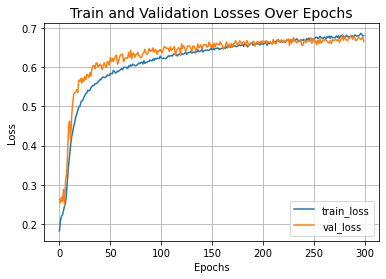

In [18]:
plt.plot(history.history["accuracy"], label="train_loss")
plt.plot(history.history['val_accuracy'], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()

In [48]:
hist_df = pd.DataFrame(history.history)
hist_df.head()

,loss,accuracy,val_loss,val_accuracy
0,2.427261,0.181999,1.931312,0.262190
1,2.102516,0.207531,1.838387,0.253831
2,2.009136,0.219269,1.810858,0.268041
3,1.968165,0.222543,1.921017,0.256896
4,1.926746,0.234282,1.759196,0.288381


In [49]:
hist_csv_file = 'custom_cnn_300epoch_history.csv'
with open("./histories/"+hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

In [12]:
model = FER_Model()
checkpoint_filepath = "./tmp-cnn/checkpoint-model-custom-cnn-adam-300-epoch"
model.load_weights(checkpoint_filepath)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 48, 48, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 256)       7168      
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 512)       1180160   
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 512)      2048      
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 512)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 512)       0     

In [13]:
y_pred = model.predict(x_test/255)

113/113 [==============================] - 8s 24ms/step


In [14]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print(matrix)

[[261  10  31  17  60  15  73]
 [ 10  34   1   2   4   0   5]
 [ 51   6 179  12 113  49  86]
 [ 10   1  10 787   7  19  61]
 [ 47   1  33  26 386   8 152]
 [ 12   1  25  17   7 345   8]
 [ 20   4  12  43  68  10 450]]


In [19]:
from sklearn import metrics
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = matrix, display_labels = ['Angry','Disgust','Fear','Happy','Sad','Surprise','Neutral'])

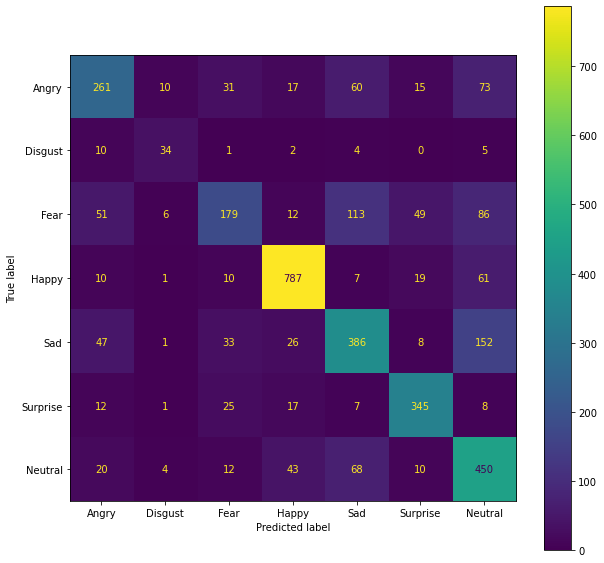

In [21]:
cm_display.plot()
plt.rcParams["figure.figsize"] = (10,10)
plt.show()

In [17]:
from sklearn.metrics import classification_report

In [18]:
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.64      0.56      0.59       467
           1       0.60      0.61      0.60        56
           2       0.62      0.36      0.45       496
           3       0.87      0.88      0.87       895
           4       0.60      0.59      0.59       653
           5       0.77      0.83      0.80       415
           6       0.54      0.74      0.62       607

    accuracy                           0.68      3589
   macro avg       0.66      0.65      0.65      3589
weighted avg       0.68      0.68      0.67      3589

